# <font color=green>deepBreaks Applications</font>
## Predicting the Phenotype of an Opsin From its Amino Acid Sequence...
## This Version of our pipeline uses deepBreaks v. 1.1.0! 
[Env name == deepBreaks]
</p>

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following text is a script written in mySQL format. You can copy and paste this directly into a mySQL text file or query window within mySQL workbench.*
```
DROP DATABASE vizphiz;
CREATE DATABASE vizphiz;
USE vizphiz;

CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus  varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);

CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);

CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);

CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
``` 

In [1]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
import pandas as pd
import jenkspy 
from matplotlib import pyplot as plt

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[12])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [ ]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('opsindb.tsv', 'r')
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")

    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.opsins (opsinid, genefamily, genenames, genus, species, db, accession, dna, aa, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")


# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Input Order)

2. Strategy = FFT-NS-2 // G-INS-1

In [56]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
import pandas as pd
import jenkspy 
import datetime
import os
from matplotlib import pyplot as plt

In [57]:
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
data_rep_dir = str(f'vizphiz_classifer_data_splits_{dt_label}')
os.makedirs(data_rep_dir)

In [58]:
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
rod = re.compile('Rh[0-2]|exoRh')
d = re.compile("^NM_001014890.2$|^NM_001014890$")
iec = re.compile("Limenitis|Papilio")



mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

props = ["LambdaMax"]
wds_max = []
wds_ni_max = []
rod_max = []

for x in myresult:
  
  wds_max.append(float(x[4]))

  if (inv.match(x[2]) or iec.match(x[0])):
    pass
  else:  
    wds_ni_max.append(float(x[4]))

  if rod.match(x[2]):
    if (inv.match(x[2]) or iec.match(x[0])):
       pass
    else: 
      rod_max.append(float(x[4]))


wds_hist_df = pd.DataFrame(columns=props, data=wds_max)
wds_ni_hist_df = pd.DataFrame(columns=props, data=wds_ni_max)
rod_hist_df = pd.DataFrame(columns=props, data=rod_max)
hist_list = [wds_hist_df, wds_ni_hist_df, rod_hist_df]

print(hist_list[0])

     LambdaMax
0        502.0
1        502.0
2        481.0
3        494.0
4        494.0
..         ...
856      444.0
857      449.0
858      448.0
859      450.0
860      453.0

[861 rows x 1 columns]


[  0. 396. 467. 496. 511. 611.]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


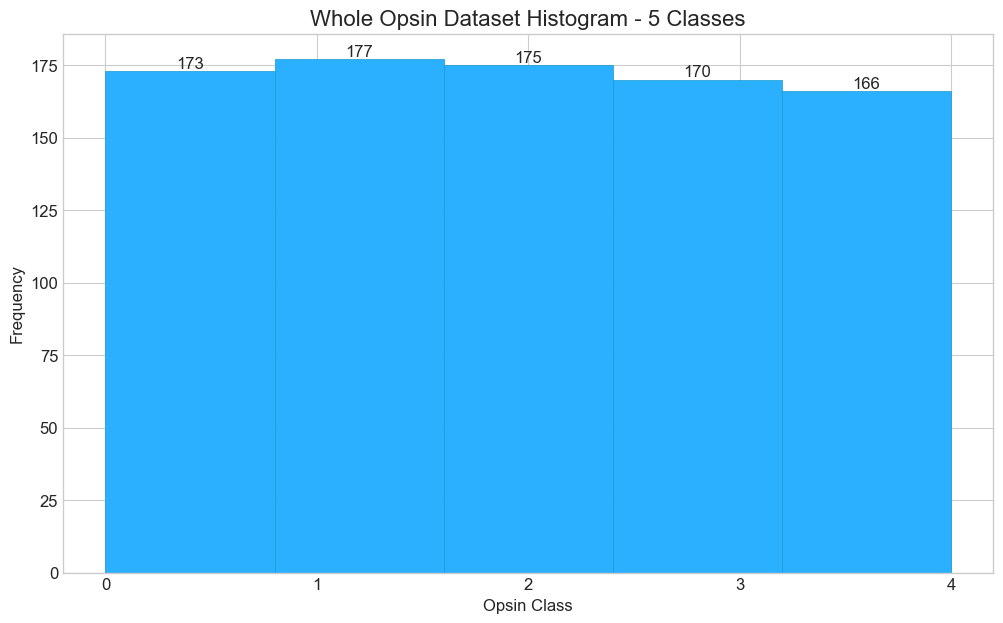

[  0. 360. 396. 433. 467. 488. 496. 501. 511. 536. 611.]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


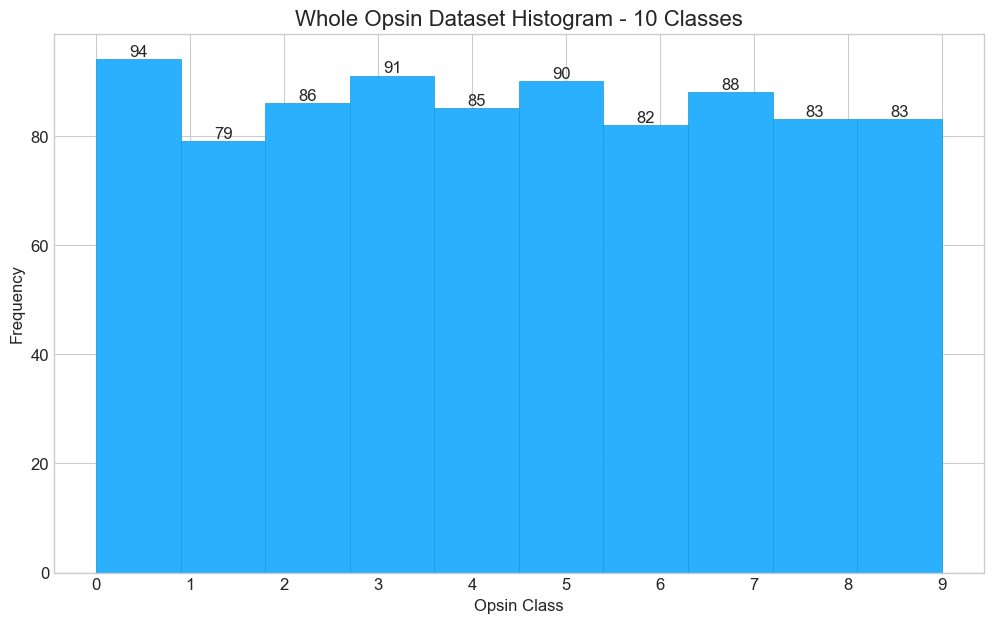

[  0.         359.         363.         396.         420.
 441.66666667 467.         485.         491.         496.
 500.         503.         511.         526.33333333 548.66666667
 611.        ]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


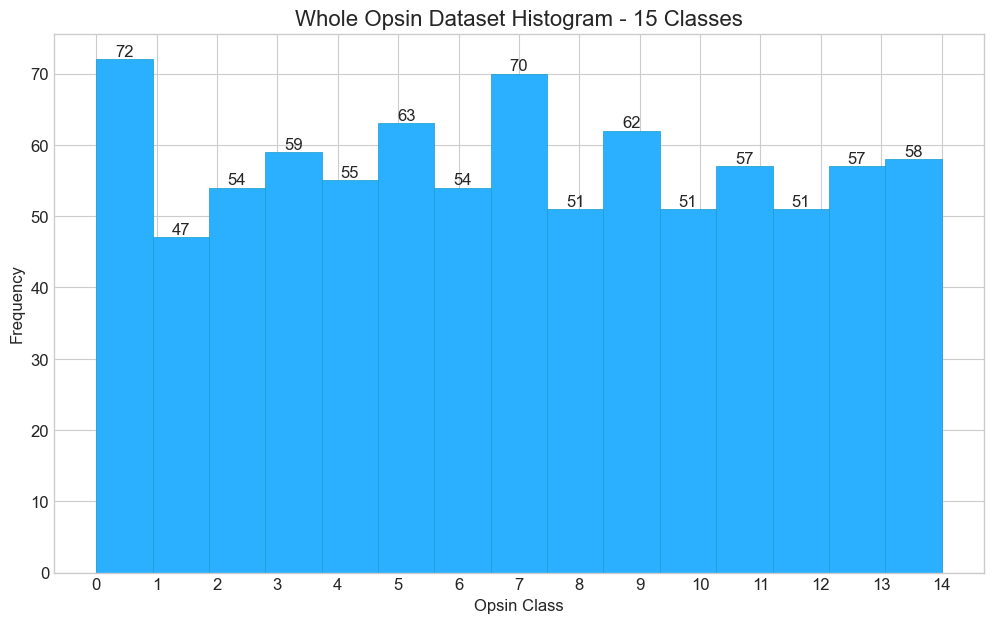

[array([  0., 396., 467., 496., 511., 611.]), array([  0., 360., 396., 433., 467., 488., 496., 501., 511., 536., 611.]), array([  0.        , 359.        , 363.        , 396.        ,
       420.        , 441.66666667, 467.        , 485.        ,
       491.        , 496.        , 500.        , 503.        ,
       511.        , 526.33333333, 548.66666667, 611.        ])]
[  0. 385. 460. 492. 503. 578.]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


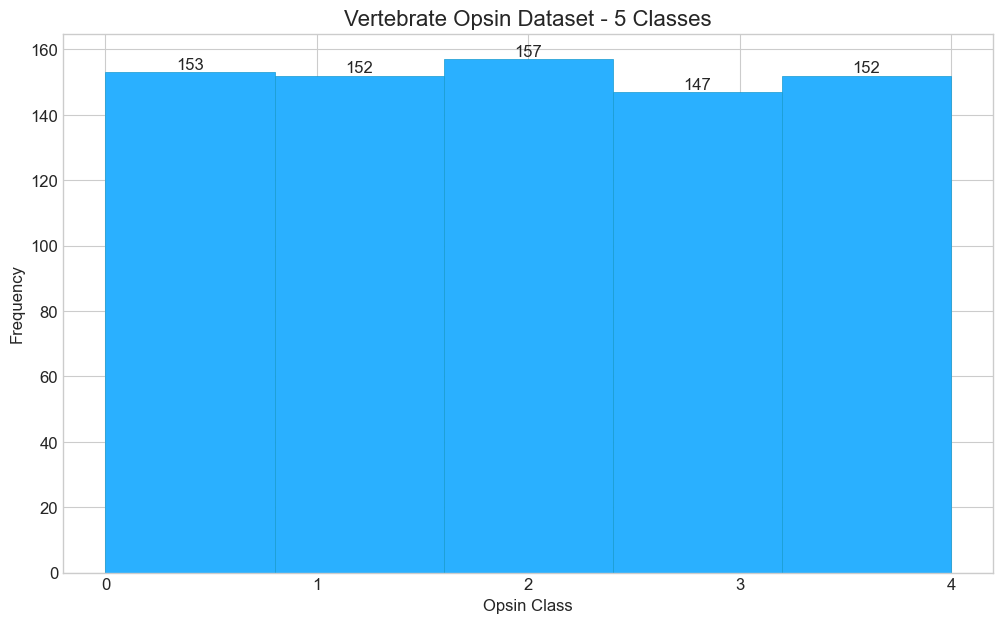

[  0. 360. 385. 421. 460. 486. 492. 499. 503. 520. 578.]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


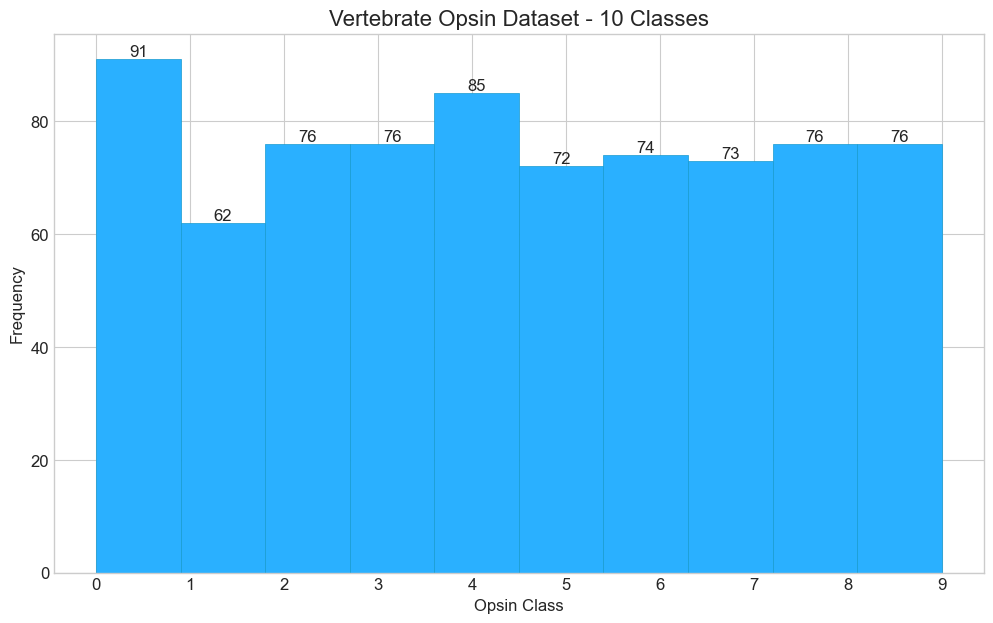

[  0.         359.         361.         385.         416.
 438.         460.         482.         488.         492.
 497.         500.33333333 503.         513.66666667 533.
 578.        ]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


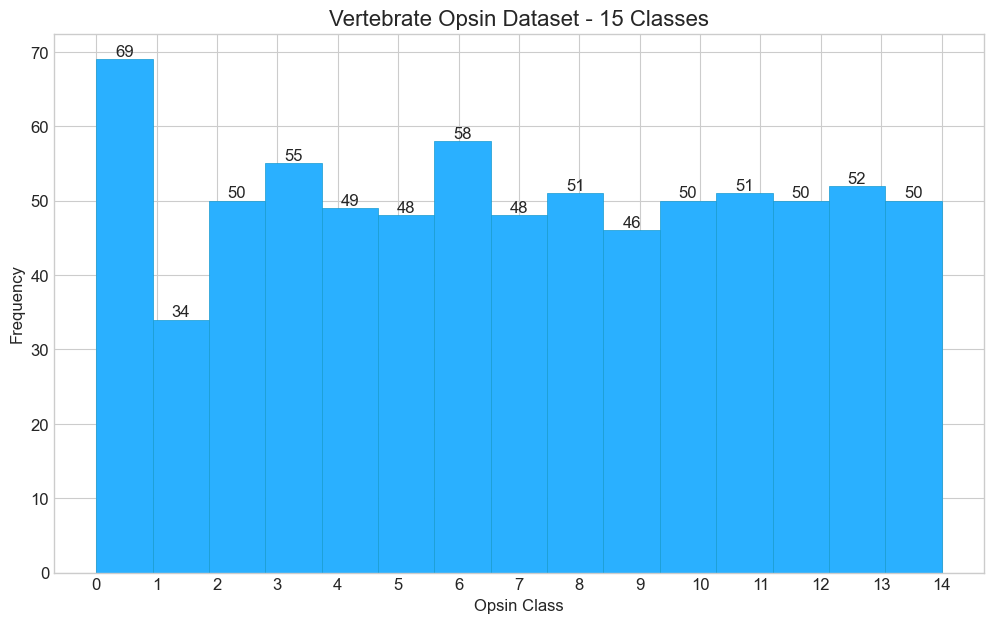

[array([  0., 385., 460., 492., 503., 578.]), array([  0., 360., 385., 421., 460., 486., 492., 499., 503., 520., 578.]), array([  0.        , 359.        , 361.        , 385.        ,
       416.        , 438.        , 460.        , 482.        ,
       488.        , 492.        , 497.        , 500.33333333,
       503.        , 513.66666667, 533.        , 578.        ])]
[  0. 486. 492. 499. 503. 554.]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


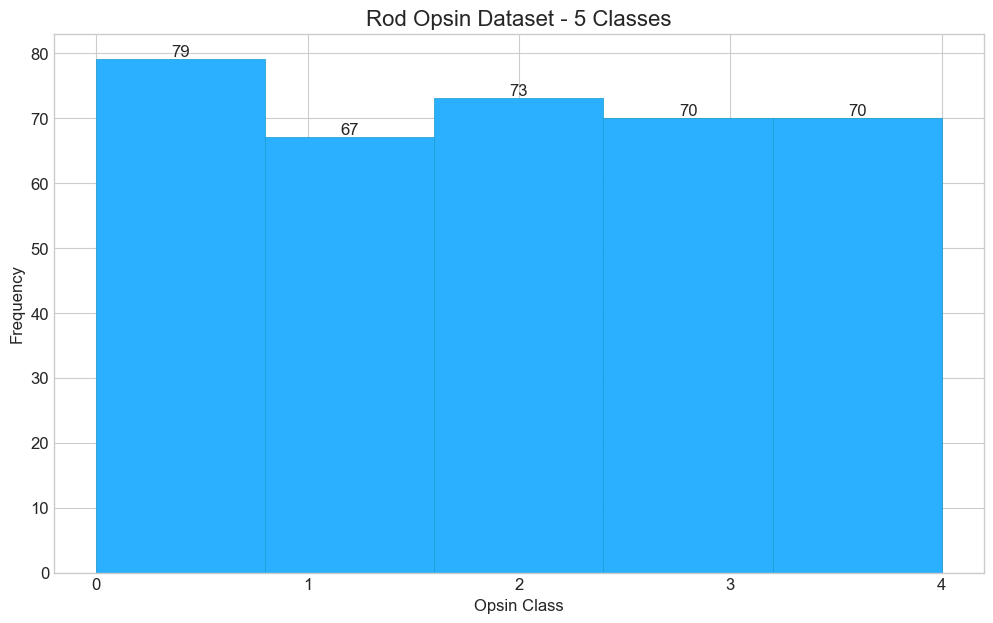

[  0.  475.6 486.  489.  492.  496.  499.  501.  503.  510.  554. ]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


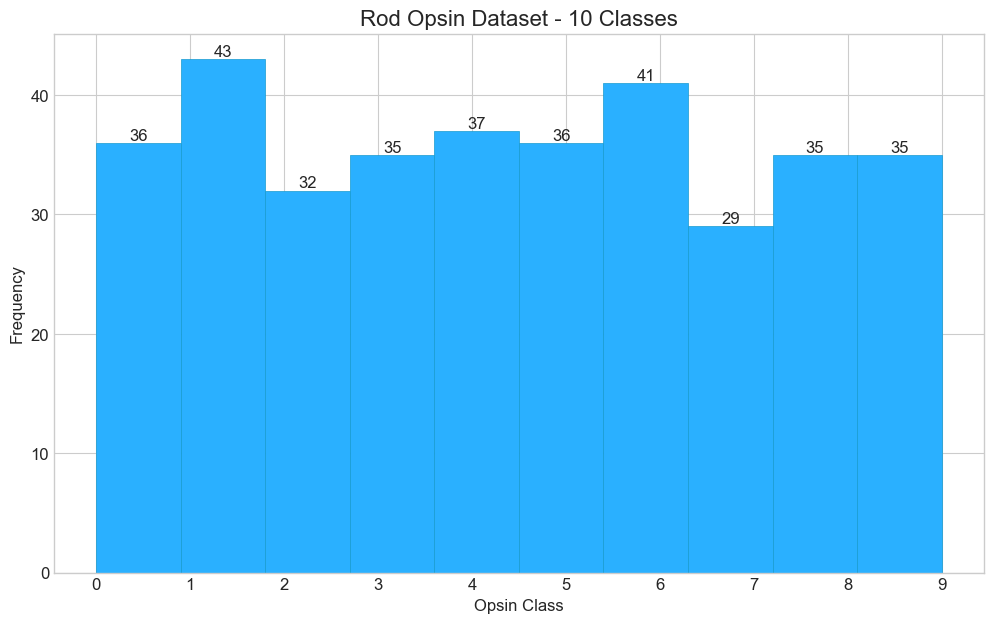

[  0.         467.         482.         486.         488.
 490.33333333 492.         495.         497.46666667 499.
 500.         502.         503.         508.         514.
 554.        ]


C:\Users\safra\AppData\Local\Temp\ipykernel_36088\543927573.py:55: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


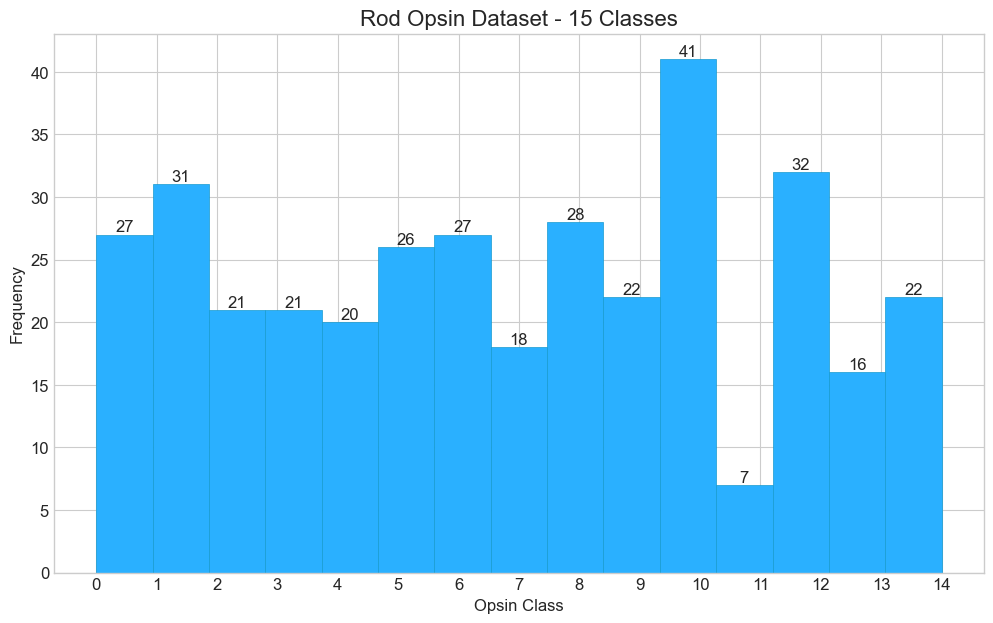

[array([  0., 486., 492., 499., 503., 554.]), array([  0. , 475.6, 486. , 489. , 492. , 496. , 499. , 501. , 503. ,
       510. , 554. ]), array([  0.        , 467.        , 482.        , 486.        ,
       488.        , 490.33333333, 492.        , 495.        ,
       497.46666667, 499.        , 500.        , 502.        ,
       503.        , 508.        , 514.        , 554.        ])]


In [59]:
wds_class_list = []
wds_ni_class_list = []
rod_class_list = []
class_file = f"./{data_rep_dir}/data_class_list.tsv"
x = 0

for hist_df in hist_list:
    if x == 0:
        title = 'Whole Opsin Dataset Histogram'
    elif x == 1:
        title = 'Vertebrate Opsin Dataset'
    else:
        title = 'Rod Opsin Dataset'
    rdt = title.replace(' ','_')

    five = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins=True)
    fiv_list = five[1]
    print(five[1])
    plt.rcParams.update({'font.size': 12})
    hist_df['bin_qcut5'] = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins = False)
    plt.figure(figsize=(12,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    counts, edges, bars = plt.hist(hist_df['bin_qcut5'], bins=5, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    plt.bar_label(bars)
    plt.title(f'{title} - 5 Classes', fontsize = 16) 
    plt.xlabel('Opsin Class') 
    plt.ylabel('Frequency')
    fileout = f'{data_rep_dir}/{rdt}_5_classes.pdf'
    plt.xticks(range(min(hist_df['bin_qcut5']), max(hist_df['bin_qcut5'])+1))
    plt.savefig(fileout) 
    plt.show()

    ten = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins=True)
    ten_list = ten[1]
    print(ten[1])
    hist_df['bin_qcut10'] = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins = False)
    plt.figure(figsize=(12,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    counts, edges, bars = plt.hist(hist_df['bin_qcut10'], bins=10, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    plt.bar_label(bars)
    plt.title(f'{title} - 10 Classes', fontsize = 16) 
    plt.xlabel('Opsin Class') 
    plt.ylabel('Frequency') 
    plt.xticks(range(min(hist_df['bin_qcut10']), max(hist_df['bin_qcut10'])+1))
    fileout = f'{data_rep_dir}/{rdt}_10_classes.pdf'
    plt.savefig(fileout) 
    plt.show()


    fifteen = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins=True)
    fif_list = fifteen[1]
    print(fifteen[1])
    hist_df['bin_qcut15'] = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins = False)
    plt.figure(figsize=(12,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid
    counts, edges, bars = plt.hist(hist_df['bin_qcut15'], bins=15, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    plt.bar_label(bars)
    plt.title(f'{title} - 15 Classes', fontsize = 16) 
    plt.xlabel('Opsin Class') 
    plt.ylabel('Frequency')
    plt.xticks(range(min(hist_df['bin_qcut15']), max(hist_df['bin_qcut15'])+1))
    fileout = f'{data_rep_dir}/{rdt}_15_classes.pdf'
    plt.savefig(fileout) 
    plt.show()


    if x == 0:
        wds_class_list = [fiv_list, ten_list, fif_list]
        print(wds_class_list)
        with open(class_file, 'a') as f:
            f.write("Whole Dataset Class Ranges\n")
            f.write(f'Five Classes\t{fiv_list}\n')
            f.write(f'Ten Classes\t{ten_list}\n')
            f.write(f'Fifteen Classes\t{fif_list}\n')
    elif x == 1:
        wds_ni_class_list = [fiv_list, ten_list, fif_list]
        print(wds_ni_class_list)
        with open(class_file, 'a') as f:
            f.write("Vertebrate Dataset Class Ranges\n")
            f.write(f'Five Classes\t{fiv_list}\n')
            f.write(f'Ten Classes\t{ten_list}\n')
            f.write(f'Fifteen Classes\t{fif_list}\n')
    else:
        rod_class_list = [fiv_list, ten_list, fif_list]
        print(rod_class_list)
        with open(class_file, 'a') as f:
            f.write("Rod Dataset Class Ranges\n")
            f.write(f'Five Classes\t{fiv_list}\n')
            f.write(f'Ten Classes\t{ten_list}\n')
            f.write(f'Fifteen Classes\t{fif_list}\n')

    x+=1

In [48]:
#Allows for automatic multifacet class assignment during datasplitting
def class_assignment(lmax, class_bounds):
  #lmax = x[4]
  #class_bounds = class_list[splits]
  opclass = 0
  while opclass < len(class_bounds)-1:
    if (round(lmax) > int(class_bounds[opclass]) and round(lmax) <= int(class_bounds[opclass+1])):
        return(opclass)
      
    else:
      opclass += 1

In [60]:
#STEP 1: Extract Data From Vizphiz``
#directory preperation

#3 different 'version' // 'splits' of the raw sequence data 
wd_output = f'{data_rep_dir}/wds.txt'
wd_ni_output = f'{data_rep_dir}/wds_ni.txt'
rod_output = f'{data_rep_dir}/rod.txt'

#Regular Metadata Files
wds_metadata = f'{data_rep_dir}/wds_meta.tsv'
wd_ni_metadata = f'{data_rep_dir}/wds_ni_meta.tsv'
rh_metadata = f'{data_rep_dir}/rod_meta.tsv'

#Classifer Specific Metadata Files
class_ni_metadata = ['class_ni_meta_5.tsv','class_ni_meta_10.tsv','class_ni_meta_15.tsv']
class_metadata = ['class_meta_5.tsv','class_meta_10.tsv','class_meta_15.tsv']
class_rod_metadata = ['class_rod_meta_5.tsv','class_rod_meta_10.tsv','class_rod_meta_15.tsv']

invert_counter = 'invert_data.tsv'
#class_ranges = 'classifier_ranges.tsv'
m = 0
s = 0
l = 0
r = 0
c = 0
d = re.compile("^NM_001014890.2$|^NM_001014890%")
iec = re.compile("Limenitis|Papilio")
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

class_bounds = ten_list

for x in myresult:       

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)
 
       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")

          c += 1 
          #This makes the fasta format file
          seq = ">S" + str(c)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(rod_output, 'a') as f:

        p = re.compile('Rh[0-2]|exoRh')
        if p.match(x[2]):
          if r == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            r+=1
            #This makes the fasta format file
            seq = ">S" + str(r)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#CLASS METADATA SECTION          
       for splits in range(len(class_metadata)): 
        with open(f'{data_rep_dir}/{class_metadata[splits]}', 'a') as h:
            #This makes the metadata formatted for a classification model. 
          if m == 1:
            h.write("\tOpsin_Class\n")
            h.write("Bovine\t" + str(class_assignment(500.000, wds_class_list[splits])) + "\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:  
            md = "S" + str(m) + "\t" + str(class_assignment(x[4], wds_class_list[splits])) + "\n"
            h.write(md)

        with open(f'{data_rep_dir}/{class_ni_metadata[splits]}', 'a') as h:
          p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
          if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            if c == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, wds_ni_class_list[splits])) + "\n")

            
            md = "S" + str(c) + "\t" + str(class_assignment(x[4], wds_ni_class_list[splits])) + "\n"
            h.write(md)

        with open(f'{data_rep_dir}/{class_rod_metadata[splits]}', 'a') as h:
            #This makes the metadata formatted for a classification model. 
          p = re.compile('Rh[0-3]|exoRh')
          if p.match(x[2]):
            if r == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, rod_class_list[splits])) + "\n")
            if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
              pass
            else:  
              md = "S" + str(r) + "\t" + str(class_assignment(x[4], rod_class_list[splits])) + "\n"
              h.write(md)


#REGULAR METADATA SECTION
       with open(wds_metadata, 'a') as g:
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")
        if (d.match(x[3]) or x[4] == 0):
          pass
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")

          md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(rh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('Rh[0-3]|exoRh')

        if p.match(x[2]):
          if r == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:  
            md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)



# <font color=red>STEP 2: Format Alignments for 'deepBreaks'</font>
## REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2

In [ ]:
#enter list of aligned text files here.
inputs = ['wds_aligned.txt','wds_ni_aligned.txt','rod_aligned.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_fmt.fasta','wds_ni_fmt.fasta','rod_fmt.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

direcory preparation
reading meta-data
reading fasta file
Shape of data is:  (721, 356)
['Cones' 'Rods']
Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...
Tuning et...
Tuning rf...
Tuning gbc...
mean Done
et Done
et  Done
rf Done
rf  Done
gbc Done
gbc  Done


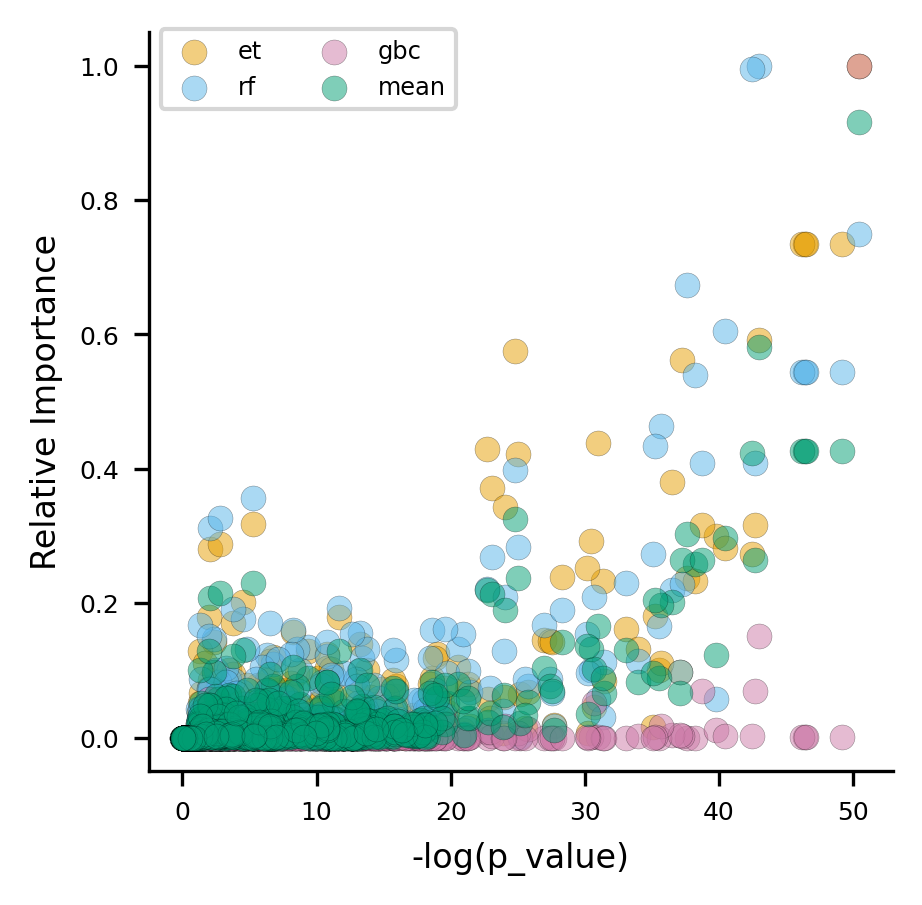

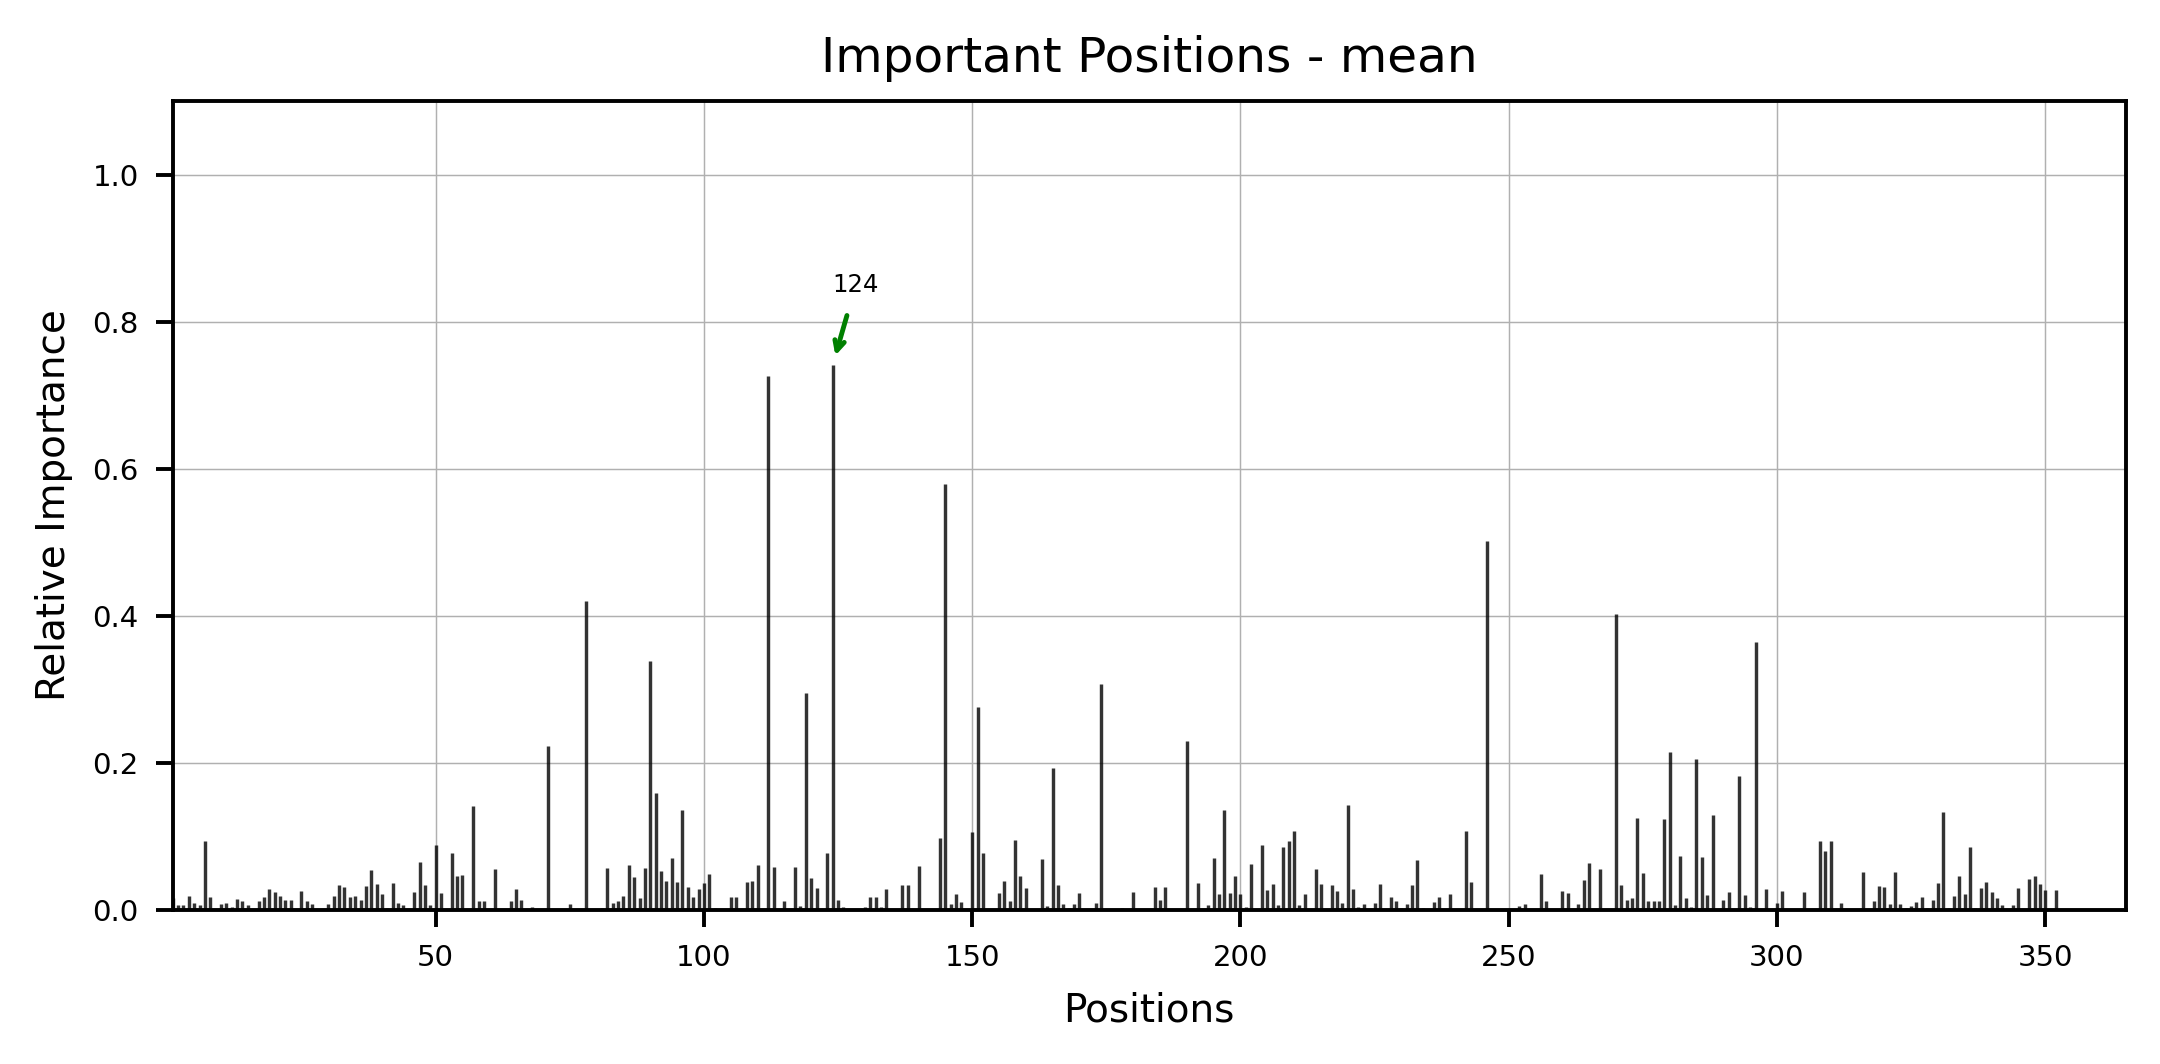

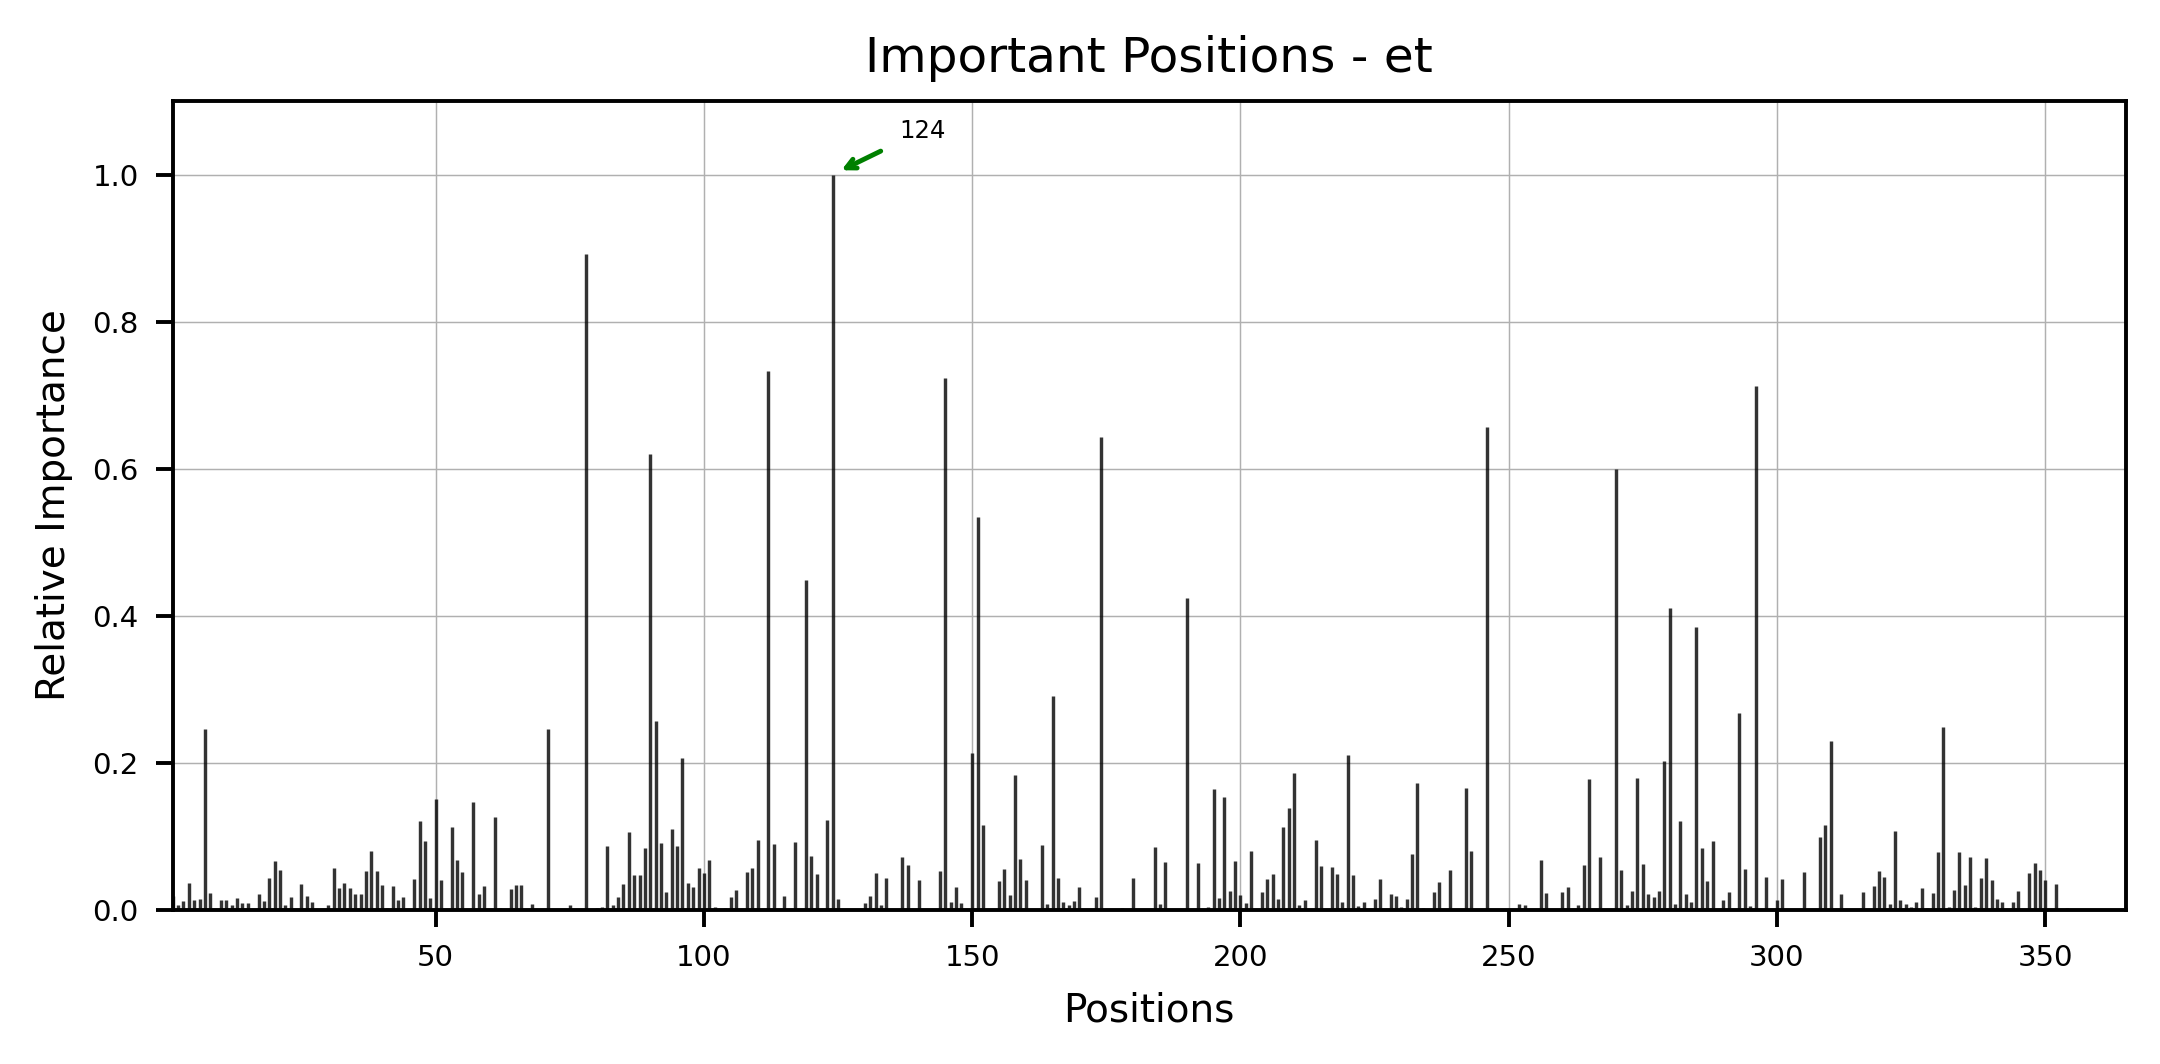

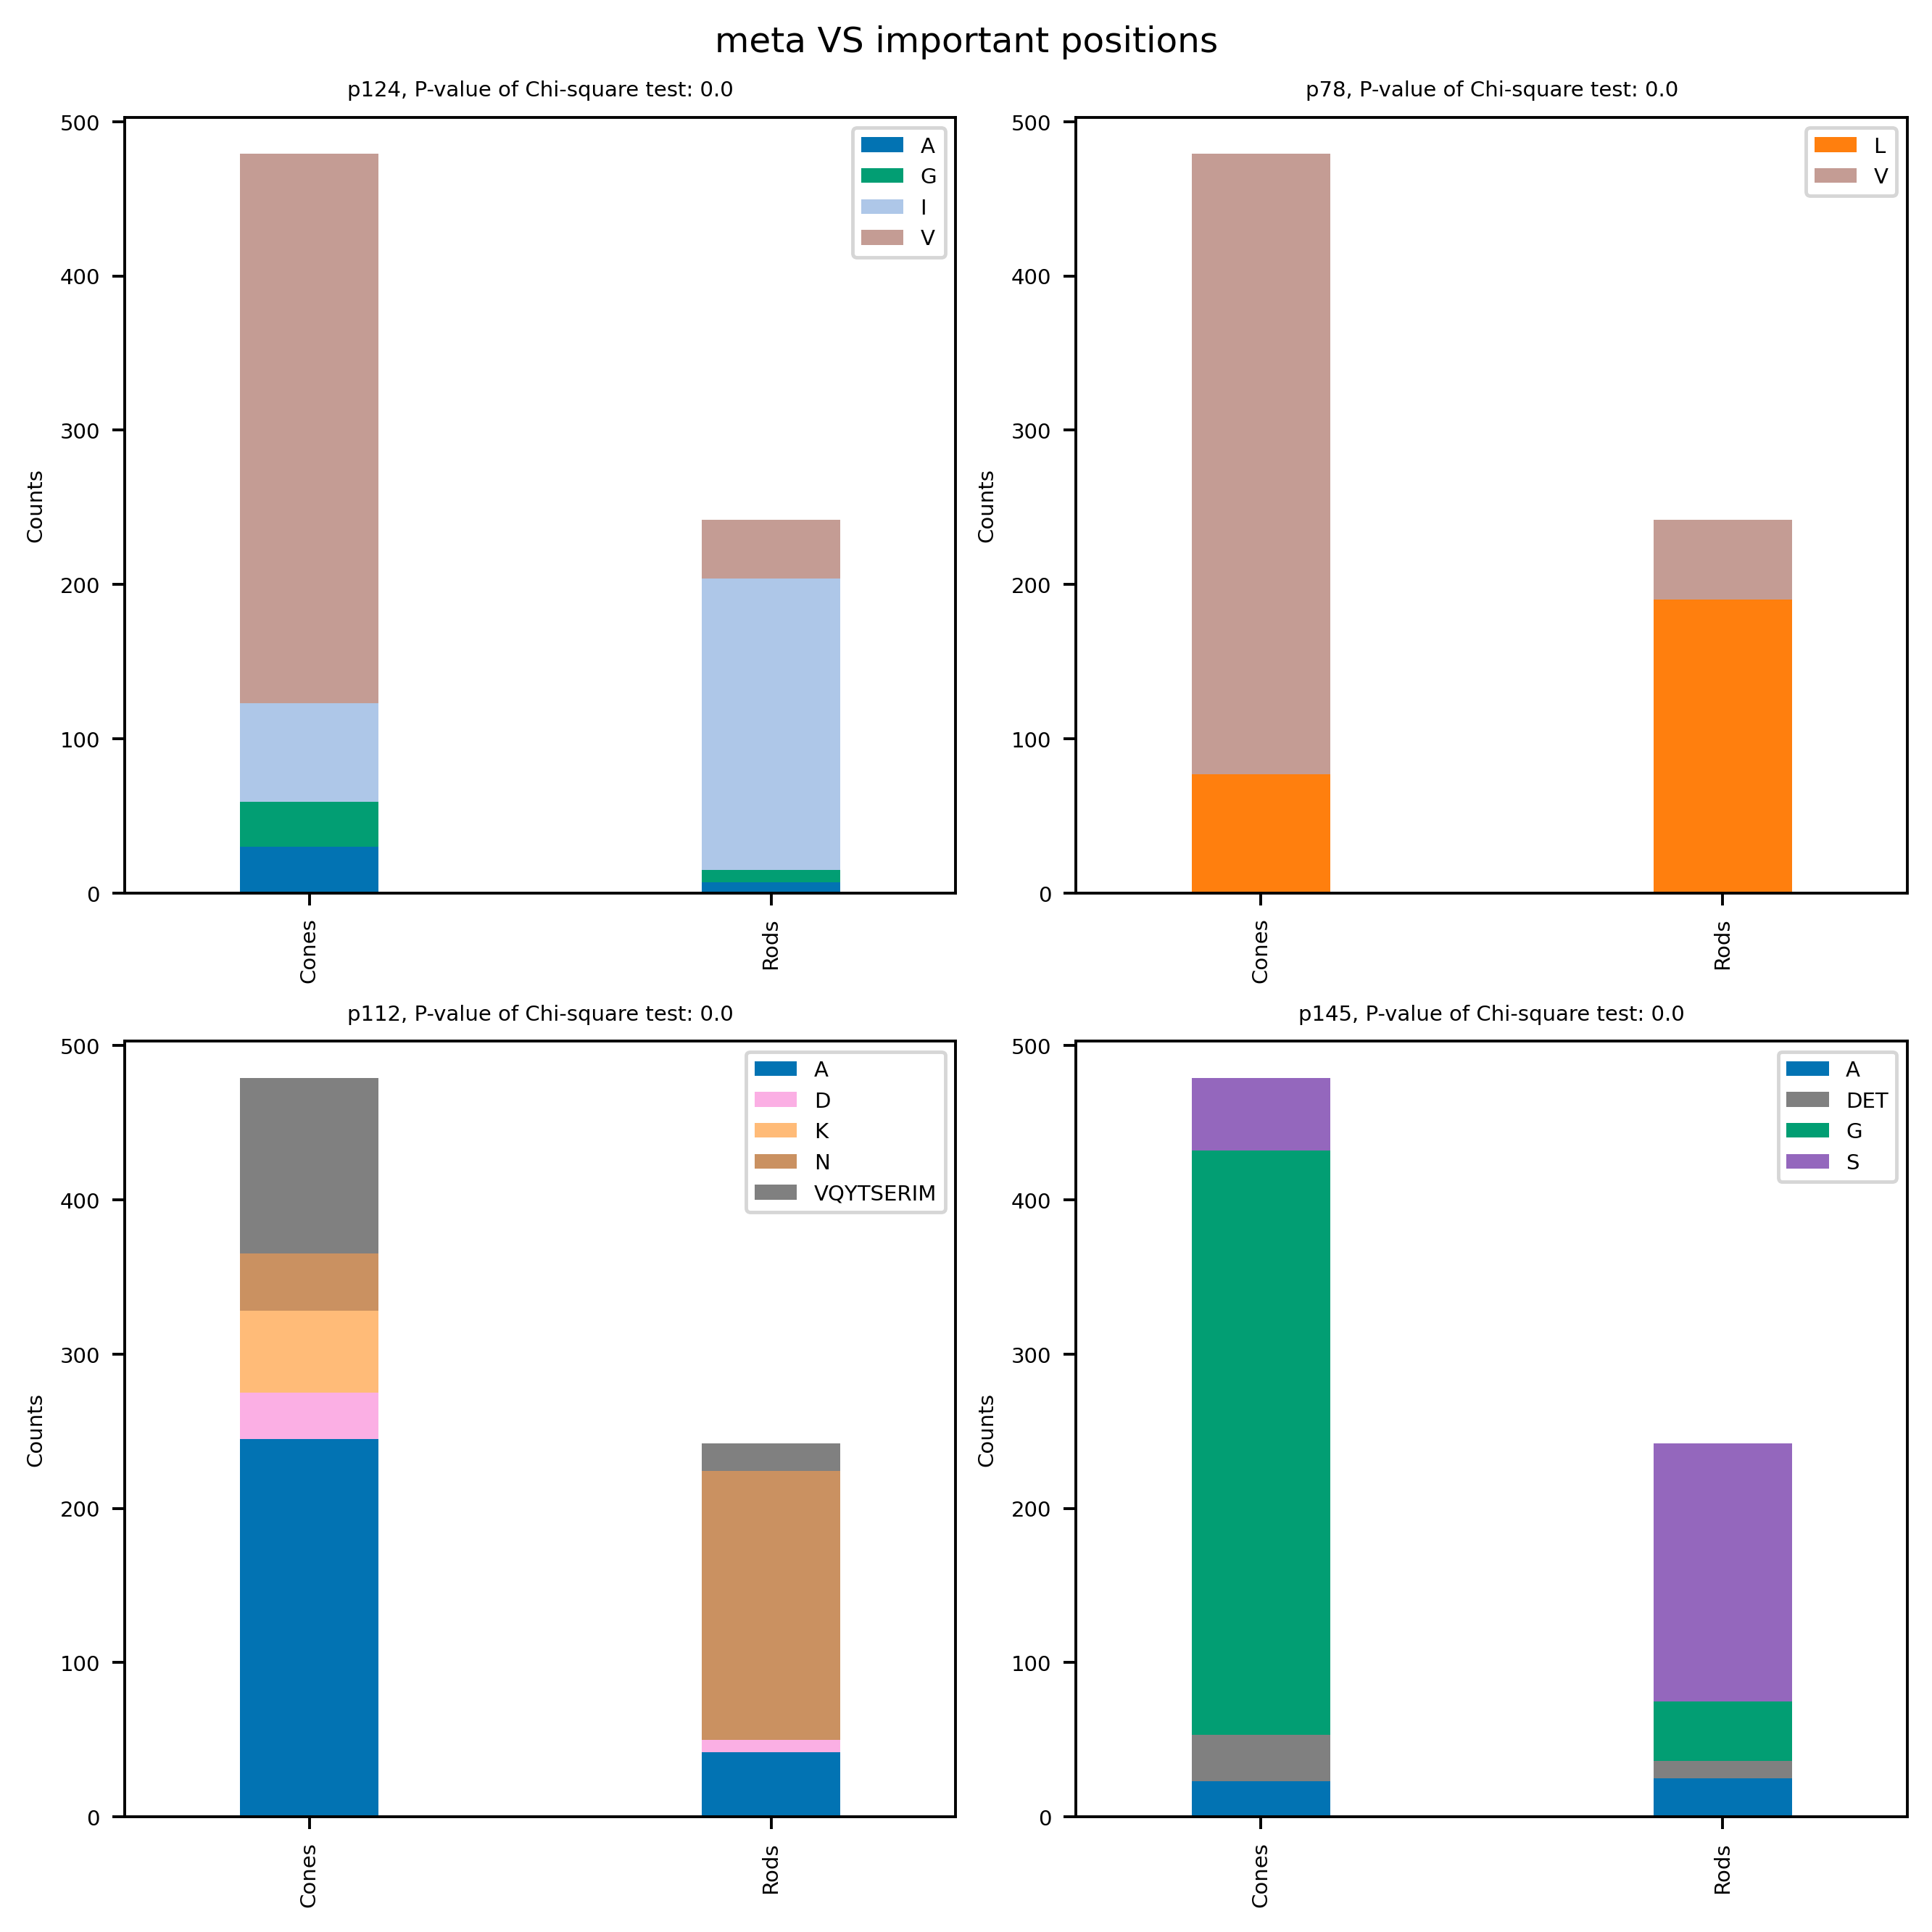

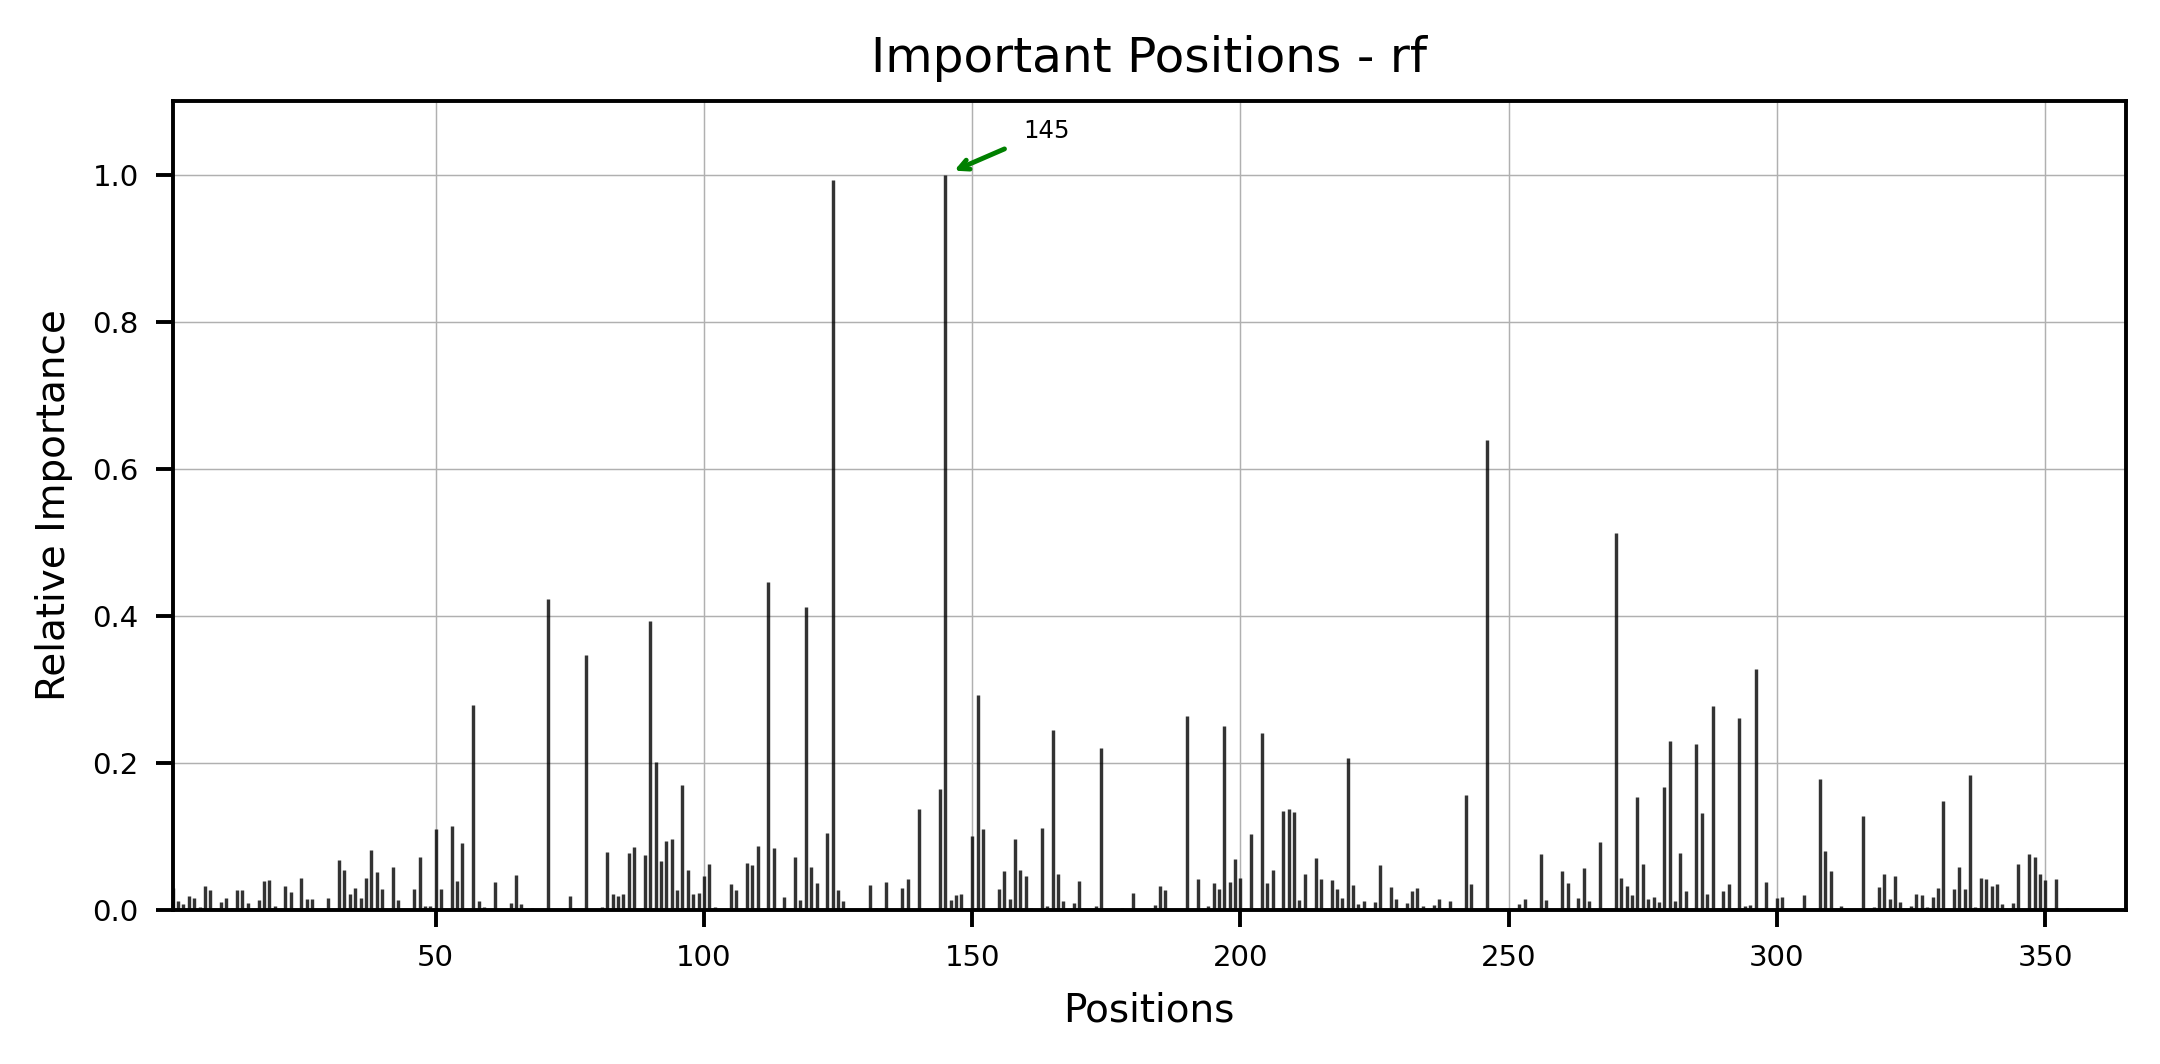

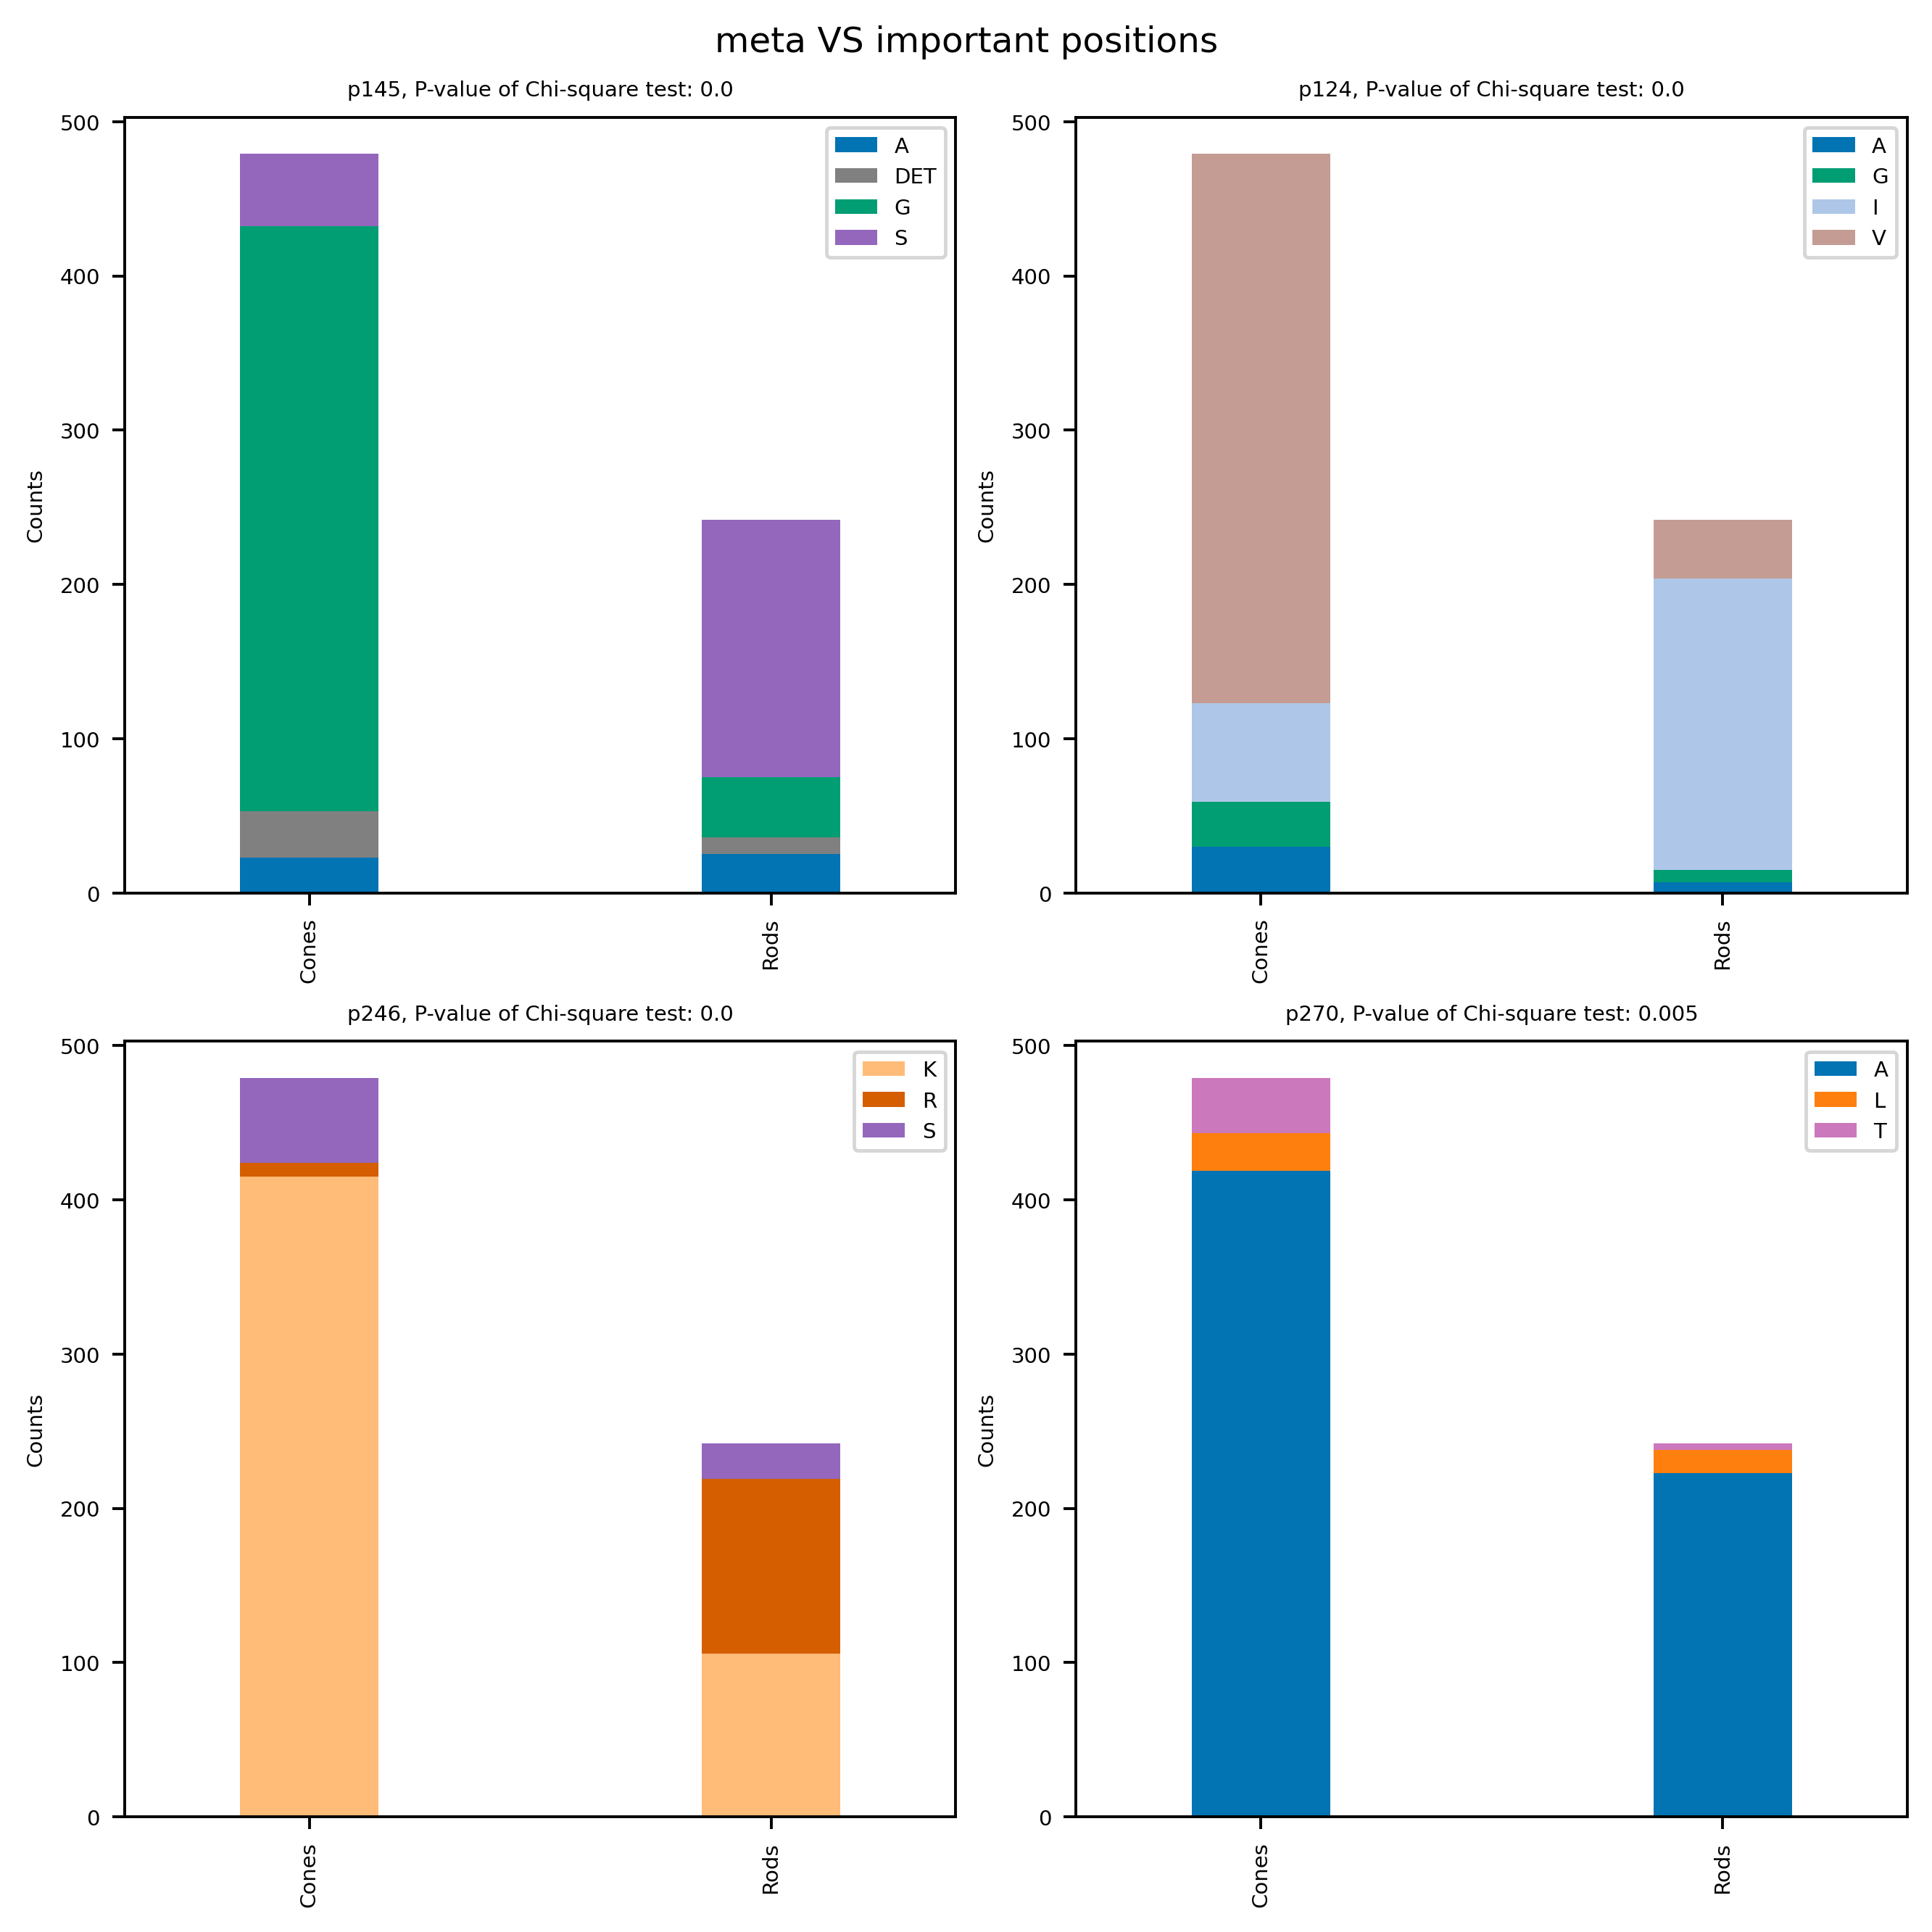

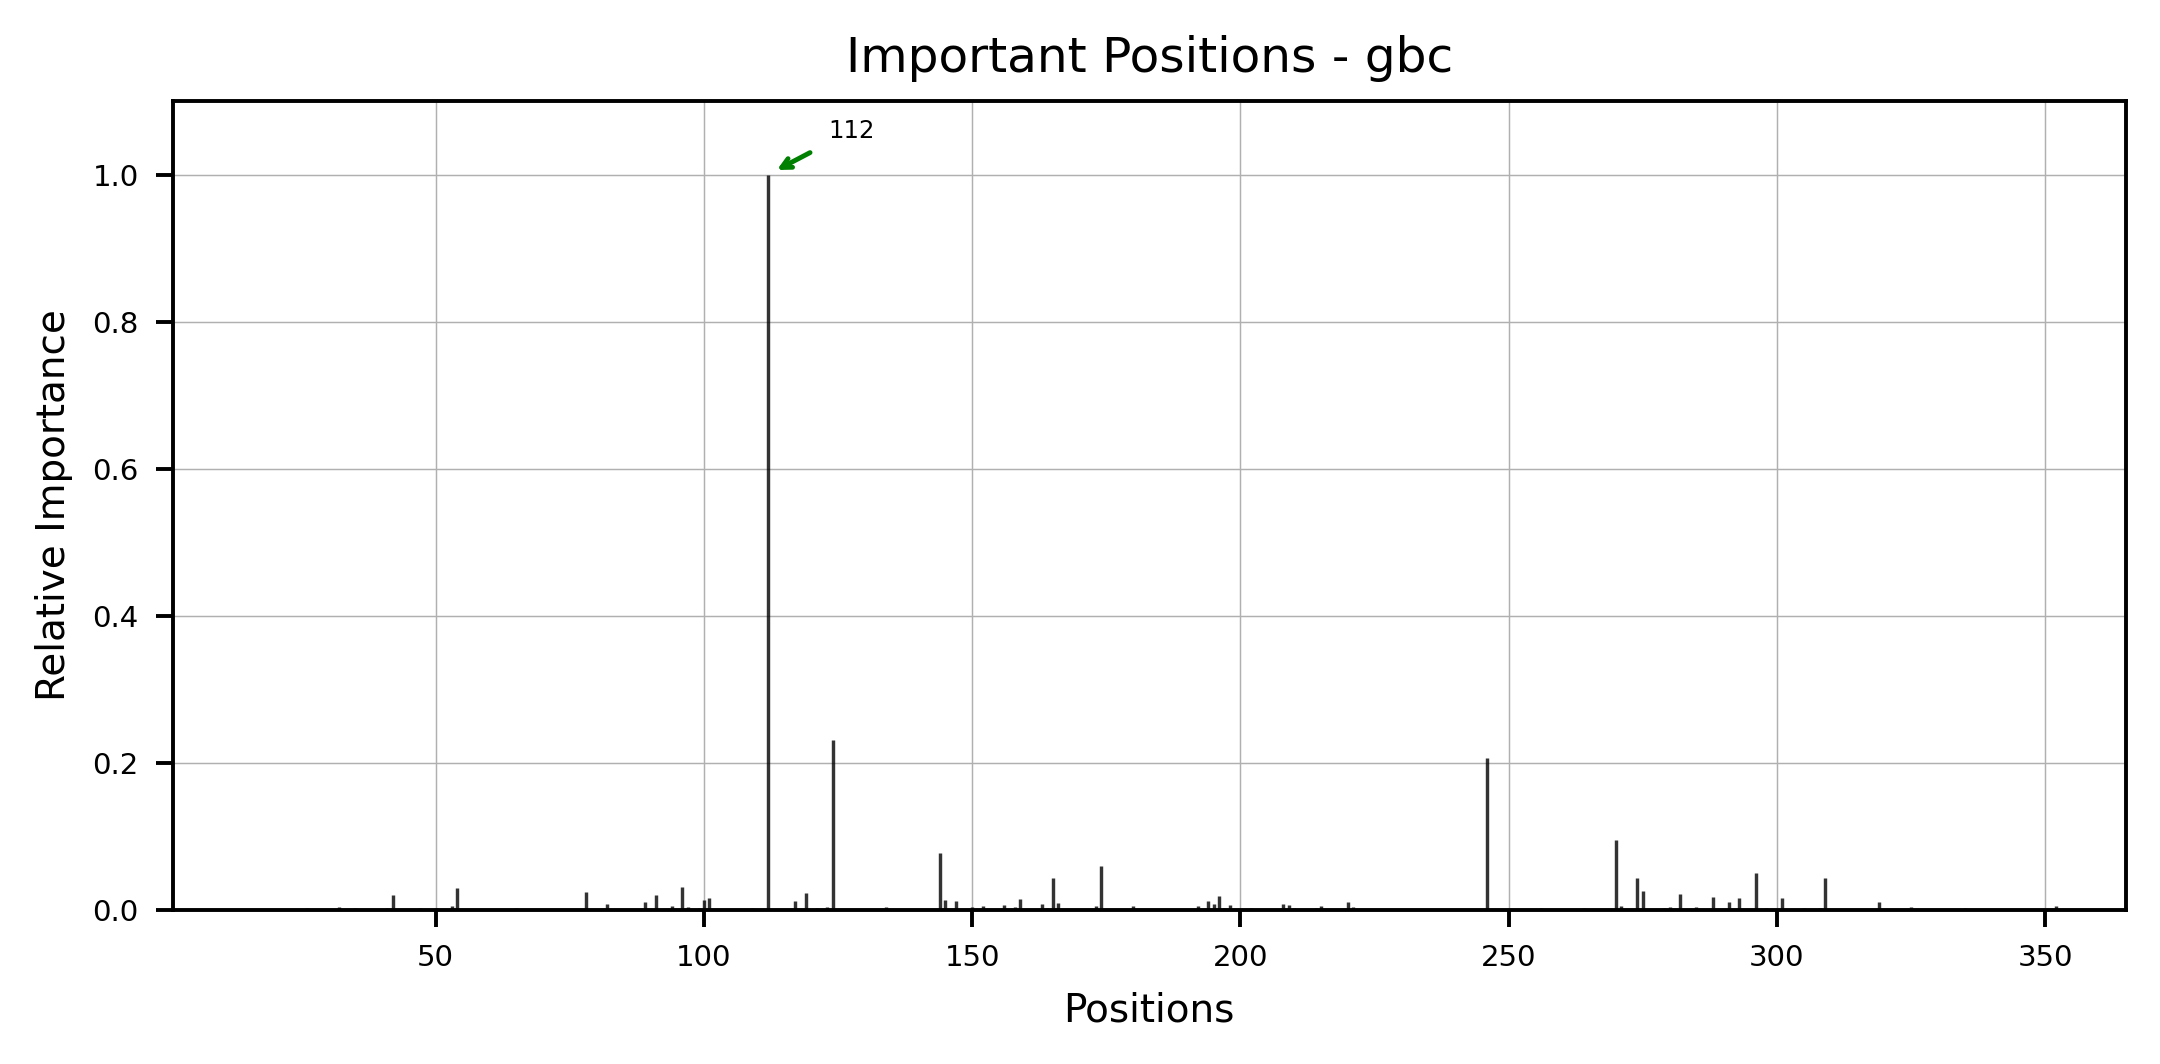

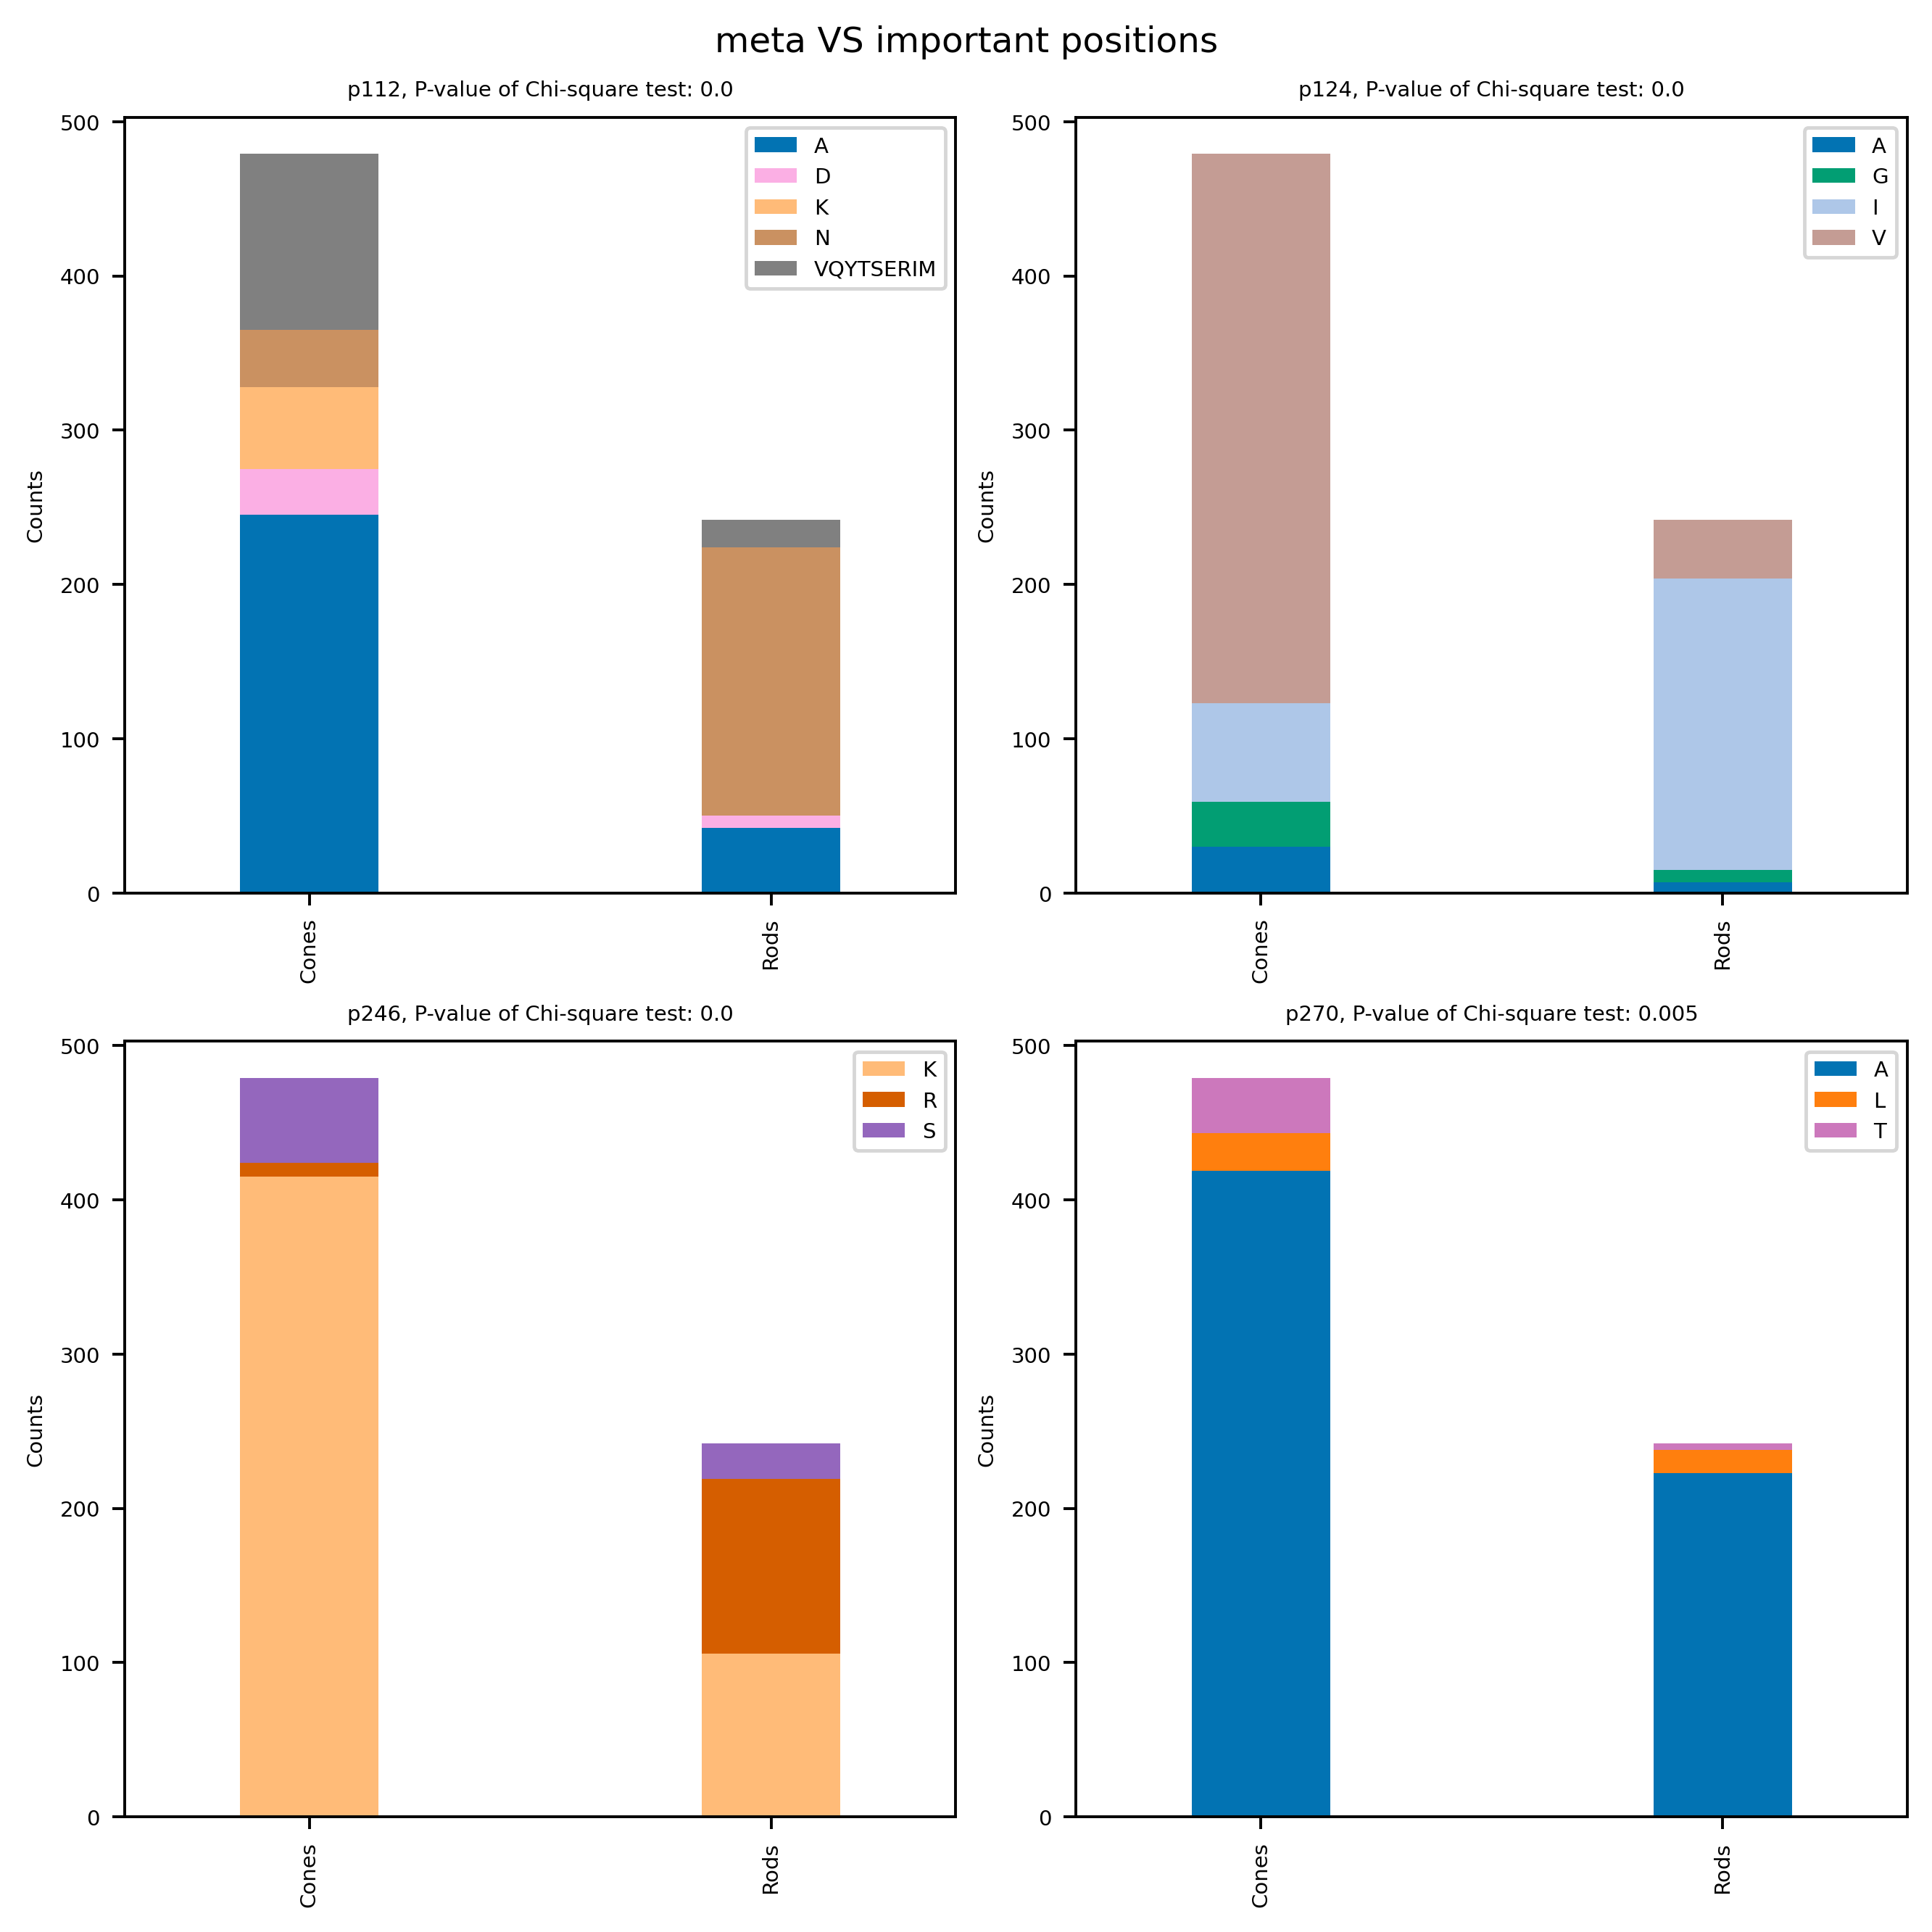

In [14]:
# creating list of all the datasplits being tested
data_rep_dir = 'vizphiz_data_splits_2023-10-16_12-13-11'
class_metadata = 'wds_ni_meta_classifier_rods_cones.tsv'
seq_file = 'wds_aligned_db_fmt.fasta'

# defining user params, file pathes, analysis type

# path to sequences
seqFileName = f'./{data_rep_dir}/{seq_file}'

meta_data = f'./{data_rep_dir}/{class_metadata}'

# name of the phenotype
mt = 'Opsin_Family'

# type of the sequences
seq_type = 'aa'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'

# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
metaFile = meta_data.split('/')[2]
metaFile = metaFile.split('.')[0]
report_dir = str(metaFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)


# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(meta_data, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.6)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)


tr.head()
#tr.to_csv(path_or_buf="test.csv",index = False,mode="w")


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)


prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25))
    ])

    
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                            models_dict=get_models(ana_type=ana_type),
                            scoring=get_scores(ana_type=ana_type),
                            report_dir=report_dir,
                            cv=10, ana_type=ana_type, cache_dir=report_dir)


prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.05, keep=True))
    ])

    
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))



top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param={},report_dir=report_dir, cv=10)


sr = summarize_results(top_models=top, report_dir=report_dir)


scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)


mean_imp = mean_importance(top, report_dir=report_dir)


dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)


tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)


for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
            X_train=tr, y_train=y, model_name=model_name,
                meta_var='meta', model_type=ana_type, report_dir=report_dir)




In [ ]:
class_metadata = 'wds_ni_meta.tsv'
seq_file = 'wds_aligned_db_fmt.fasta'

# defining user params, file pathes, analysis type

# path to sequences
seqFileName = f'./{data_rep_dir}/{seq_file}'

meta_data = f'./{data_rep_dir}/{class_metadata}'

# name of the phenotype
mt = 'Opsin_Family'

# type of the sequences
seq_type = 'aa'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'

# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')


# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
metaFile = meta_data.split('/')[2]
metaFile = metaFile.split('.')[0]
report_dir = str(metaFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)


# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(meta_data, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)


tr.head()
#tr.to_csv(path_or_buf="test.csv",index = False,mode="w")


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)


prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25))
    ])

    
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                            models_dict=get_models(ana_type=ana_type),
                            scoring=get_scores(ana_type=ana_type),
                            report_dir=report_dir,
                            cv=10, ana_type=ana_type, cache_dir=report_dir)


prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

    
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))



top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param={},report_dir=report_dir, cv=10)


sr = summarize_results(top_models=top, report_dir=report_dir)


scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)


mean_imp = mean_importance(top, report_dir=report_dir)


dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)


tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)


for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
            X_train=tr, y_train=y, model_name=model_name,
                meta_var='meta', model_type=ana_type, report_dir=report_dir)




# STEP 3.5: Classification Testing

In [ ]:
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'unseendata.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
#We no longer need to fmt the data past this point, no hot-encoding needed. The model automatically takes care of this. 
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True, gap_threshold=0.25)
print(df)
seq_name = df.index.to_list()


In [ ]:
import joblib
import pandas as pd
load_lgbm = joblib.load('lg.pkl')

In [ ]:

x=0
load_lgbm
predictions = load_lgbm.predict(df)
print(predictions)
prediction_dict = dict()
for seqs in seq_name:
    prediction_dict.update({seqs : predictions[x]})
    x+=1
print(prediction_dict)

#load_lgbm.predict_proba(tr)

# <font color=red>Step 4: Graphing Test Results -</font>

In [ ]:
import matplotlib.pyplot as p
import matplotlib.colors as colors
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import seaborn as sns
from statistics import mean



The Following Code block turns the mean wavelength of the class range into its hex code equivalent. 


In [ ]:
class_assignment = "classifier_ranges.tsv"
classes = pd.read_csv(class_assignment, delimiter='\t')
class_list = []

for c in classes['Class_Ranges']:
    print(c)
    class_list.append(c)
    print(class_list)

hex_list = []

for waves in class_list:
    gamma = 0.8
    intensity_max = 1
    wave = waves
    if wave < 380:
            red, green, blue = 0, 0, 0
    elif wave < 440:
        red = -(wave - 440) / (440 - 380)
        green, blue = 0, 1
    elif wave < 490:
        red = 0
        green = (wave - 440) / (490 - 440)
        blue = 1
    elif wave < 510:
        red, green = 0, 1
        blue = -(wave - 510) / (510 - 490)
    elif wave < 580:
        red = (wave - 510) / (580 - 510)
        green, blue = 1, 0
    elif wave < 645:
        red = 1
        green = -(wave - 645) / (645 - 580)
        blue = 0
    elif wave <= 780:
        red, green, blue = 1, 0, 0
    else:
        red, green, blue = 0, 0, 0

    # let the intensity fall of near the vision limits
    if wave < 380:
        factor = 0
    elif wave < 420:
        factor = 0.3 + 0.7 * (wave - 380) / (420 - 380)
    elif wave < 700:
        factor = 1
    elif wave <= 780:
        factor = 0.3 + 0.7 * (780 - wave) / (780 - 700)
    else:
        factor = 0

    def f(c):
        if c == 0:
                return 0
        else:
                return intensity_max * pow (c * factor, gamma)
        
    #color = f"{f(red)},{f(green)},{f(blue)}"
    color = [f(green),f(blue),f(red)] 
    print(color)
    hex = colors.rgb2hex(color, keep_alpha=True)
    hex_list.append(hex)

print(hex_list)

The following code takes a csv of predicitons and plots those predicttions relative to the knowns. 

In [ ]:
file = "wds_classifier_test_results_t2.csv"
outfile = "100_iterations_plot"
#https://academo.org/demos/wavelength-to-colour-relationship/

#Read data
table = pd.read_csv(file, delimiter = ',')

#Duplicate predicted class next to change to actual lmax 
table['Predicted_lmax'] = table.loc[:, 'Predicted_Class']
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        table['Predicted_lmax'] = table['Predicted_lmax'].replace(i,mean([class_list[i],class_list[i+1]]))
        i+=1
    else: 
        pass


colorby='Score'

#2d
sns.scatterplot(x='Lambda_Max', y='Predicted_lmax', data=table, edgecolor = 'none', color = 'black', s = 20)
plt.xlabel('Known Lambda-max (nm)')
plt.ylabel('Predicted Lambda-max (mean of class in nm)')

i = 0
alpha = 0.05
for wavelengths in class_list:
    if i+1 < len(hex_list):
        print(hex_list[i])
        plt.axhspan(class_list[i],class_list[i+1], facecolor=hex_list[i], alpha=0.15)
        i+=1
    else: 
        pass
    #place colored bands behind plot

m = plt.annotate("r^2 = {:.3f}".format(r2_score(table['Lambda_Max'],table['Predicted_lmax'])), (350, 550))
print(m)
#If no file name show on screen otherwise save pdf
if outfile == '' :
    plt.show()
else:
    fileout = outfile + '.pdf'
    plt.savefig(fileout)


# <font color=red>Step 6: Earth Movers Distance (EMD) of Test Results -</font>
The following code blocks take results from the 100 iterations test and calculates the EMD between the observed and idealized results. 

In [ ]:
from scipy.stats import wasserstein_distance


Input for EMD calculator is the list of class boundaries and the results csv from the 100 iterations test...
Use this metric to calc a p-value by doing various data perturbations...
OR
Use to compare the performance of different models!

In [ ]:
class_list = 340,360,380,420,450,480,490,495,505,520,560
class_means = []
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        mean_lambda = mean([class_list[i],class_list[i+1]])
        class_means.append(mean_lambda)
        i+=1
    else: 
        pass

#print(class_means)

class_diffs = []
i = 0
for means in class_means:
    if i+1 != len(class_means):
        #if i == 0:
            #class_diffs.append(0)
        diff_lambda = float(class_means[i+1] - class_means[i])
        class_diffs.append(diff_lambda)
        i+=1
    else: 
        pass

#These will be the weights between classes, and will be additive as the prediction gets further from the ground-truth classification.
print(class_diffs)
#Will need to make it so weight assignment has a 'row_count' corresponding to the class 'y' value of the ordered pair.
class_count = range(len(class_means))
#make a set of all possible ordered pair combinations...
#(0,0),(0,1),(0,2)....
ordered_pairs = []
#m will be our'known_class'
for m in class_count:
    i = 0
    while i <= len(class_count)-1:
        ordered_pairs.append([i,m])
        i+=1
#print(ordered_pairs)
iter_res = open("wds_classifier_test_results_t2.csv", "r",)
results_csv = csv.reader(iter_res, delimiter=",")
data_columns = ["Pred_Known","Count","Weight","Score","True_Num"]
results_df = pd.DataFrame(columns=data_columns)
results_df.Pred_Known = ordered_pairs
results_df.Count = 0 
results_df.Score = 0
results_df.Weight = 0
results_df.True_Num = 0
results_df.set_index("Pred_Known")
#print(results_df)
x = 0
for entry in results_csv:
    if x == 0:
        x+=1
    else:
        pair = [int(entry[2]),int(entry[1])]
        i = 0
        for plot in results_df.Pred_Known:
            if plot[0] == pair[0] and plot[1] == pair[1]:
                results_df.Count[i]+= 1
                results_df.Score[i] += float(entry[4])
                m = 0
                for s in results_df.Pred_Known:
                    if s[1] == pair[1] and s[0] == s[1]: 
                        results_df.True_Num[m] += 1 
                    m+=1
            i+=1
    

x = 0
for score in results_df.Score:
    if score == 0:
        results_df.Score[x] = 0.000
    else:
        score = score / results_df.Count[x]
        results_df.Score[x] = score

    x+=1
#print(results_df)

x = 0
for plot in results_df.Pred_Known:
    #iterate through and assign weights to each ordered pair...
        #weight = mean confidence score x sum of the differences between means of class range that serpate the prediction from ground truth.
    if plot[0] > plot[1]:
        i = plot[1]
        while i < plot[0]:
            results_df.Weight[x] += class_diffs[i] * results_df.Score[x]
            i+=1
    elif plot[0] < plot[1]:
        i = plot[0]
        while i < plot[1]:
            results_df.Weight[x] +=  class_diffs[i] * results_df.Score[x] 
            i+=1          
    else:
        pass
    x+=1
print(results_df)

whole_matrix = wasserstein_distance(results_df.Count.to_list(),results_df.True_Num.to_list(),results_df.Weight.to_list(),results_df.Weight.to_list())
emd = str(whole_matrix)
print(emd)

results_df.to_csv(path_or_buf="100_iter_matrix.csv",index = False,mode="w")
